# Funding Rates

This notebook collects funding rate historical data for Binance, Bybit and Hyperliquid since listing for a given symbol. 

/Users/jan.landfeld/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Binance JUPUSDT listed on 2024-01-31 18:30:00
Bybit JUPUSDT listed on 2024-01-31 15:51:07
Binance Fetch Complete ✅ Total funding entries: 2702
Bybit Fetch Progress: 25%
Bybit Fetch Progress: 30%
Bybit Fetch Progress: 35%
Bybit Fetch Progress: 80%
Bybit Fetch Progress: 95%
Bybit Fetch Progress: 100%
Bybit Fetch Complete ✅. Total funding entries: 12992
Hyperliquid Fetch Progress: 5%
Hyperliquid Fetch Progress: 10%
Hyperliquid Fetch Progress: 15%
Hyperliquid Fetch Progress: 20%
Hyperliquid Fetch Progress: 30%
Hyperliquid Fetch Progress: 35%
Hyperliquid Fetch Progress: 45%
Hyperliquid Fetch Progress: 50%
Hyperliquid Fetch Progress: 60%
Hyperliquid Fetch Progress: 65%
Hyperliquid Fetch Progress: 75%
Hyperliquid Fetch Progress: 80%
Hyperliquid Fetch Progress: 85%
Hyperliquid Fetch Progress: 90%
Hyperliquid Fetch Progress: 95%
Hyperliquid Fetch Progress: 100%
Hyperliquid Fetch Complete ✅. Total funding entries: 12249


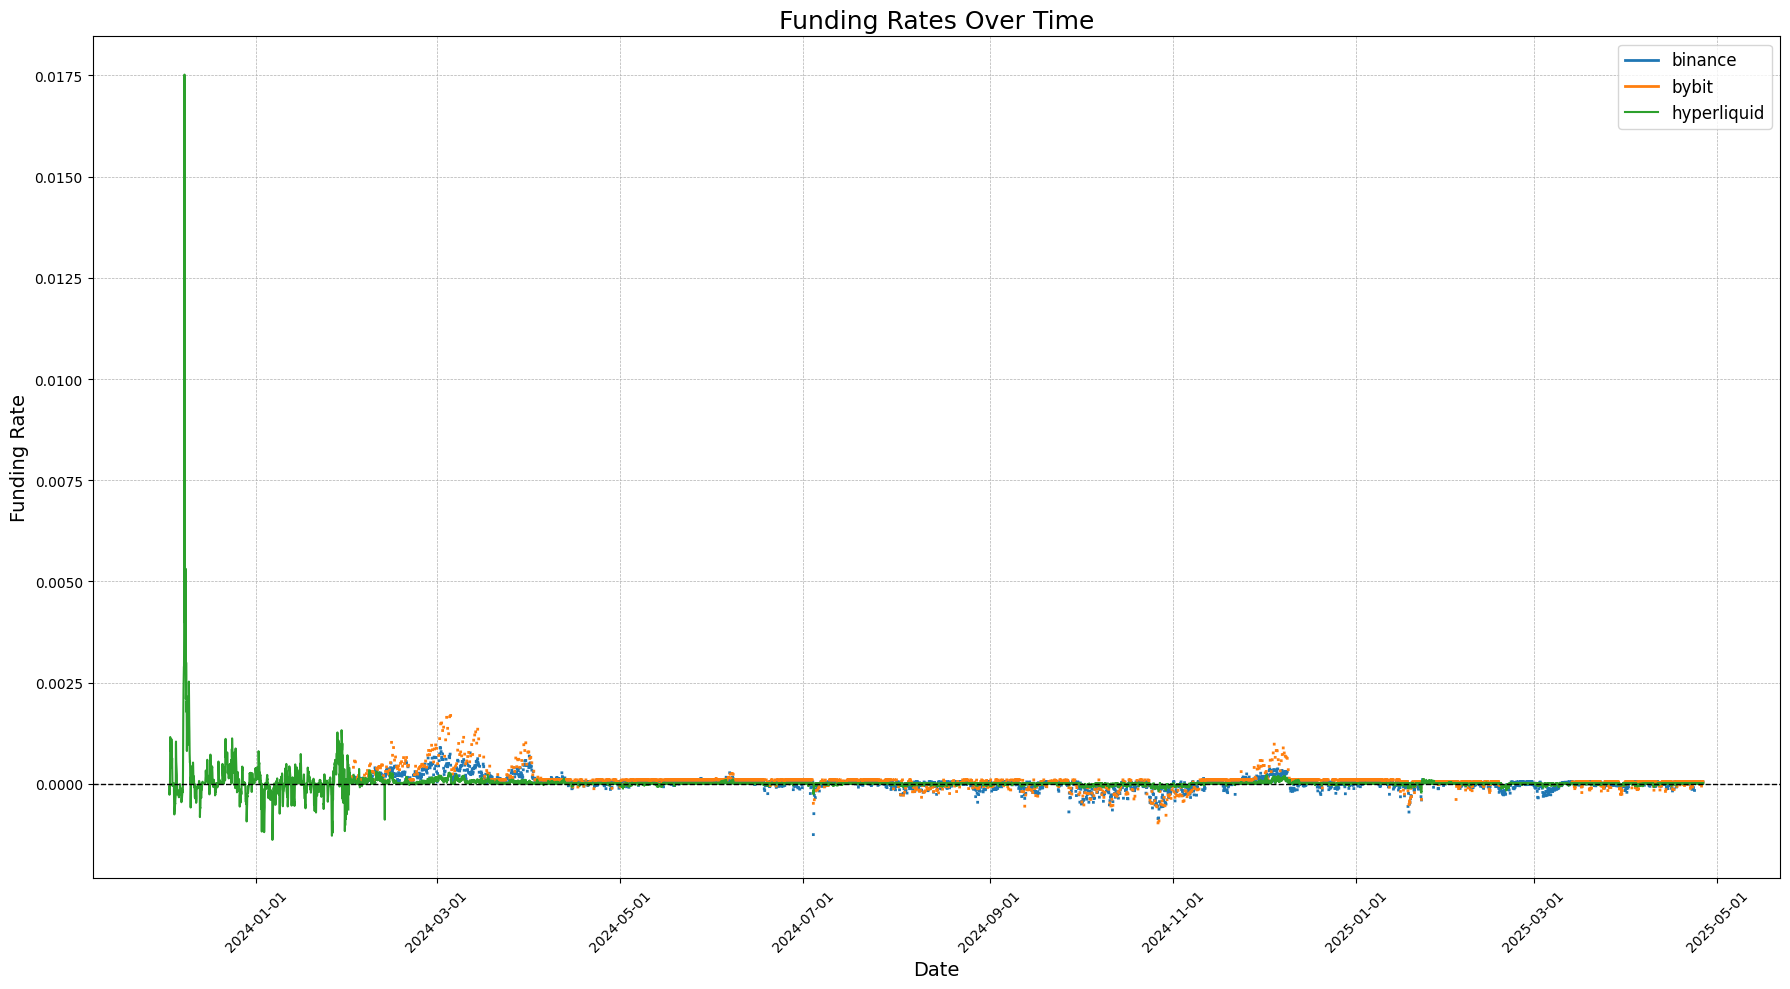

In [2]:
import requests
import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pybit.unified_trading import HTTP

# Initialize Bybit session
bybit_session = HTTP(testnet=False)

# Get listing date for Binance
def get_binance_listing_date(symbol):
    url = "https://fapi.binance.com/fapi/v1/exchangeInfo"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        for s in data["symbols"]:
            if s["symbol"] == symbol:
                listing_date = int(s["onboardDate"])
                print(f"Binance {symbol} listed on {pd.to_datetime(listing_date, unit='ms')}")
                return listing_date
    except Exception as e:
        print(f"Binance listing fetch error: {e}")
    return None

# Get listing date for Bybit
def get_bybit_listing_date(symbol_bybit, bybit_session):
    try:
        response = bybit_session.get_instruments_info(category="linear", symbol=symbol_bybit)
        if response.get("result") and response["result"].get("list"):
            item = response["result"]["list"][0]
            listing_date = int(item["launchTime"])
            print(f"Bybit {symbol_bybit} listed on {pd.to_datetime(listing_date, unit='ms')}")
            return listing_date
    except Exception as e:
        print(f"Bybit listing fetch error: {e}")
    return None

# Hyperliquid listing date (assumed)
def get_hyperliquid_listing_date():
    very_old_date = int(pd.Timestamp('2023-12-03').timestamp() * 1000)
    return very_old_date

# Binance Historical Funding
def get_binance_funding_history(symbol, start_time_ms, end_time_ms=None):
    url = "https://fapi.binance.com/fapi/v1/fundingRate"
    limit = 1000
    all_data = []

    while True:
        params = {
            "symbol": symbol,
            "startTime": start_time_ms,
            "limit": limit
        }
        if end_time_ms is not None:
            params["endTime"] = end_time_ms

        try:
            response = requests.get(url, params=params, timeout=10)
            response.raise_for_status()
            data = response.json()

            if not data:
                break

            # Add the fetched funding rates
            all_data.extend([
                {"timestamp": int(item["fundingTime"]), "fundingRate": float(item["fundingRate"])}
                for item in data
            ])

            # Move start_time_ms forward to next funding
            start_time_ms = int(data[-1]["fundingTime"]) + 1

            # If we've passed end_time_ms (if provided), break
            if end_time_ms and start_time_ms > end_time_ms:
                break

            # Be polite to API
            time.sleep(1)

        except Exception as e:
            print(f"Binance error: {e}")
            break

    print(f"Binance Fetch Complete ✅ Total funding entries: {len(all_data)}")
    return all_data


# Bybit Historical Funding
def get_bybit_funding_history(symbol_bybit, start_time, end_time, bybit_session):
    all_data = []
    chunk_size_ms = 90 * 24 * 60 * 60 * 1000
    current_start = start_time
    total_duration = end_time - start_time
    last_printed_progress = -1

    while current_start < end_time:
        current_end = min(current_start + chunk_size_ms, end_time)
        try:
            response = bybit_session.get_funding_rate_history(
                category="linear",
                symbol=symbol_bybit,
                startTime=current_start,
                endTime=current_end,
                limit=200
            )
            if response.get("result") and response["result"].get("list"):
                batch = response["result"]["list"]
                all_data.extend([
                    {"timestamp": int(item["fundingRateTimestamp"]), "fundingRate": float(item["fundingRate"])}
                    for item in batch
                ])
                last_timestamp = int(batch[-1]["fundingRateTimestamp"])
                current_start = last_timestamp + (8 * 60 * 60 * 1000)
            else:
                print(f"No more Bybit data after {pd.to_datetime(current_start, unit='ms')}")
                break

            progress = int(100 * (current_start - start_time) / total_duration)
            if progress != last_printed_progress and progress % 5 == 0:
                print(f"Bybit Fetch Progress: {progress}%")
                last_printed_progress = progress

            time.sleep(0.2)
        except Exception as e:
            print(f"Bybit error for {symbol_bybit}: {e}")
            break

    print("Bybit Fetch Complete ✅. Total funding entries:", len(all_data))
    return all_data

# Hyperliquid Historical Funding
def get_hyperliquid_funding_history(coin, start_time_ms, end_time_ms):
    url = "https://api.hyperliquid.xyz/info"
    headers = {"Content-Type": "application/json"}
    all_data = []
    batch_size = 7 * 24 * 60 * 60 * 1000
    current_start = start_time_ms
    total_duration = end_time_ms - start_time_ms
    last_printed_progress = -1

    while current_start < end_time_ms:
        current_end = min(current_start + batch_size, end_time_ms)
        payload = {
            "type": "fundingHistory",
            "coin": coin,
            "startTime": current_start,
            "endTime": current_end
        }
        try:
            response = requests.post(url, headers=headers, json=payload, timeout=10)
            response.raise_for_status()
            batch = response.json()
            if not batch:
                print(f"No data between {pd.to_datetime(current_start, unit='ms')} and {pd.to_datetime(current_end, unit='ms')}")
                current_start = current_end + 1
                continue
            all_data.extend([
                {"timestamp": int(item["time"]), "fundingRate": float(item["fundingRate"])}
                for item in batch
            ])
            current_start = current_end + 1
            progress = int(100 * (current_start - start_time_ms) / total_duration)
            if progress != last_printed_progress and progress % 5 == 0:
                print(f"Hyperliquid Fetch Progress: {progress}%")
                last_printed_progress = progress
            time.sleep(0.1)
        except Exception as e:
            print(f"Hyperliquid error: {e}")
            break

    print("Hyperliquid Fetch Complete ✅. Total funding entries:", len(all_data))
    return all_data

# Fetch historical funding from all sources
def fetch_historical_funding(symbol_binance, symbol_bybit, symbol_hyperliquid):
    now = int(time.time() * 1000)
    binance_listing = get_binance_listing_date(symbol_binance) or (now - 365 * 24 * 60 * 60 * 1000)
    bybit_listing = get_bybit_listing_date(symbol_bybit, bybit_session) or (now - 365 * 24 * 60 * 60 * 1000)
    hyperliquid_listing = get_hyperliquid_listing_date()

    start_time_ms = min(binance_listing, bybit_listing, hyperliquid_listing)


    return {
        "binance": get_binance_funding_history(symbol_binance, start_time_ms, now),
        "bybit": get_bybit_funding_history(symbol_bybit, start_time_ms, now, bybit_session),
        "hyperliquid": get_hyperliquid_funding_history(symbol_hyperliquid, start_time_ms, now)
    }

# Convert and plot funding rates
def process_and_plot_funding(funding_histories):
    dfs = {}
    for exchange, history in funding_histories.items():
        df = pd.DataFrame(history)
        if not df.empty:
            df['timestamp'] = pd.to_datetime(pd.to_numeric(df['timestamp'], errors='coerce'), unit='ms')
            df = df.set_index('timestamp')

            # Group by timestamp and mean to avoid duplicates
            df = df.groupby(level=0).mean()

            df = df.rename(columns={"fundingRate": exchange})
            dfs[exchange] = df

    combined = pd.concat(dfs.values(), axis=1)
    combined = combined.sort_index()

    plt.figure(figsize=(18, 10))
    for col in combined.columns:
        if col in ["binance", "bybit"]:
            plt.step(combined.index, combined[col], where="post", label=col, linewidth=2)
        else:
            plt.plot(combined.index, combined[col], label=col, linewidth=1.5)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title("Funding Rates Over Time", fontsize=18)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Funding Rate", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return combined
# Main runner
if __name__ == "__main__":
    symbol_binance = "JUPUSDT"
    symbol_bybit = "JUPUSDT"
    symbol_hyperliquid = "JUP"

    funding_histories = fetch_historical_funding(
        symbol_binance,
        symbol_bybit,
        symbol_hyperliquid
    )

    combined_df = process_and_plot_funding(funding_histories)


## Analyzing the funding rates

We do simple annualization, descriptive analysis and some plotting. Next step is OI-weighted data etc.

In [3]:
print(combined_df.tail(10))

                         binance    bybit  hyperliquid
timestamp                                             
2025-04-26 04:00:00.000      NaN  0.00005          NaN
2025-04-26 04:00:00.001  0.00005      NaN          NaN
2025-04-26 04:00:00.079      NaN      NaN     0.000013
2025-04-26 05:00:00.089      NaN      NaN     0.000013
2025-04-26 06:00:00.080      NaN      NaN     0.000013
2025-04-26 07:00:00.011      NaN      NaN     0.000013
2025-04-26 08:00:00.000  0.00005  0.00005          NaN
2025-04-26 08:00:00.041      NaN      NaN     0.000013
2025-04-26 09:00:00.020      NaN      NaN     0.000013
2025-04-26 10:00:00.013      NaN      NaN     0.000013


### Data cleaning

In [10]:
# Normalize timestamps to remove milliseconds, keep them exactly on the hour
combined_df.index = combined_df.index.floor('H')
combined_df = combined_df.groupby(combined_df.index).mean()
print(combined_df.tail(20))

                      binance     bybit  hyperliquid
timestamp                                           
2025-04-25 15:00:00       NaN       NaN     0.000013
2025-04-25 16:00:00  0.000002  0.000023     0.000013
2025-04-25 17:00:00       NaN       NaN     0.000013
2025-04-25 18:00:00       NaN       NaN     0.000013
2025-04-25 19:00:00       NaN       NaN     0.000013
2025-04-25 20:00:00  0.000048 -0.000053     0.000013
2025-04-25 21:00:00       NaN       NaN     0.000013
2025-04-25 22:00:00       NaN       NaN     0.000013
2025-04-25 23:00:00       NaN       NaN     0.000013
2025-04-26 00:00:00  0.000050  0.000050     0.000013
2025-04-26 01:00:00       NaN       NaN     0.000013
2025-04-26 02:00:00       NaN       NaN     0.000013
2025-04-26 03:00:00       NaN       NaN     0.000013
2025-04-26 04:00:00  0.000050  0.000050     0.000013
2025-04-26 05:00:00       NaN       NaN     0.000013
2025-04-26 06:00:00       NaN       NaN     0.000013
2025-04-26 07:00:00       NaN       NaN     0.

/var/folders/td/k0m1s7_n6ps90j1fyg7rqt_c0000gn/T/ipykernel_51821/3329425146.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  combined_df.index = combined_df.index.floor('H')


Annualize based on the real data - exchanges can change the funding periods.

In [15]:
def annualize_funding_dynamic(df, col_name):
    """Annualize funding based on actual time gaps between funding payments."""
    funding_times = df[df[col_name].notnull()].index

    # Calculate the difference between funding timestamps (in hours)
    funding_diffs = funding_times.to_series().diff().dt.total_seconds() / 3600

    # Shift diffs backward, so each timestamp gets the correct "period"
    funding_diffs = funding_diffs.shift(-1)

    # Map the hours between fundings back into the DataFrame
    df[f'{col_name}_hours_between_funding'] = funding_diffs

    # Calculate annualized funding rate
    # Annualization factor = (365 * 24) / hours_between
    annualization_factor = (365 * 24) / df[f'{col_name}_hours_between_funding']

    df[f'{col_name}_annualized'] = df[col_name] * annualization_factor

    return df

for col in ['binance', 'bybit', 'hyperliquid']:
    combined_df = annualize_funding_dynamic(combined_df, col)
print(combined_df.tail(10))

                     binance    bybit  hyperliquid  \
timestamp                                            
2025-04-26 01:00:00      NaN      NaN     0.000013   
2025-04-26 02:00:00      NaN      NaN     0.000013   
2025-04-26 03:00:00      NaN      NaN     0.000013   
2025-04-26 04:00:00  0.00005  0.00005     0.000013   
2025-04-26 05:00:00      NaN      NaN     0.000013   
2025-04-26 06:00:00      NaN      NaN     0.000013   
2025-04-26 07:00:00      NaN      NaN     0.000013   
2025-04-26 08:00:00  0.00005  0.00005     0.000013   
2025-04-26 09:00:00      NaN      NaN     0.000013   
2025-04-26 10:00:00      NaN      NaN     0.000013   

                     binance_hours_between_funding  binance_annualized  \
timestamp                                                                
2025-04-26 01:00:00                            NaN                 NaN   
2025-04-26 02:00:00                            NaN                 NaN   
2025-04-26 03:00:00                            NaN     

In [19]:
# Select annualized columns
annualized_cols = ['binance_annualized', 'bybit_annualized', 'hyperliquid_annualized']

# Basic descriptive statistics
summary_stats = combined_df[annualized_cols].describe()

# Add skewness and kurtosis
summary_stats.loc['skew'] = combined_df[annualized_cols].skew()
summary_stats.loc['kurtosis'] = combined_df[annualized_cols].kurtosis()

print("📊 Summary Statistics for Annualized Funding Rates:")
print(summary_stats)


📊 Summary Statistics for Annualized Funding Rates:
          binance_annualized  bybit_annualized  hyperliquid_annualized
count            2701.000000       1512.000000            12248.000000
mean                0.056435          0.097508                0.246182
std                 0.355177          0.285561                2.729735
min                -2.742515         -1.114863              -12.112277
25%                -0.063948          0.024000                0.036343
50%                 0.109500          0.109500                0.109500
75%                 0.109500          0.109500                0.109500
max                 1.954794          1.852028              153.477032
skew                0.139862          1.521866               31.371825
kurtosis            6.173945          8.114103             1527.569664


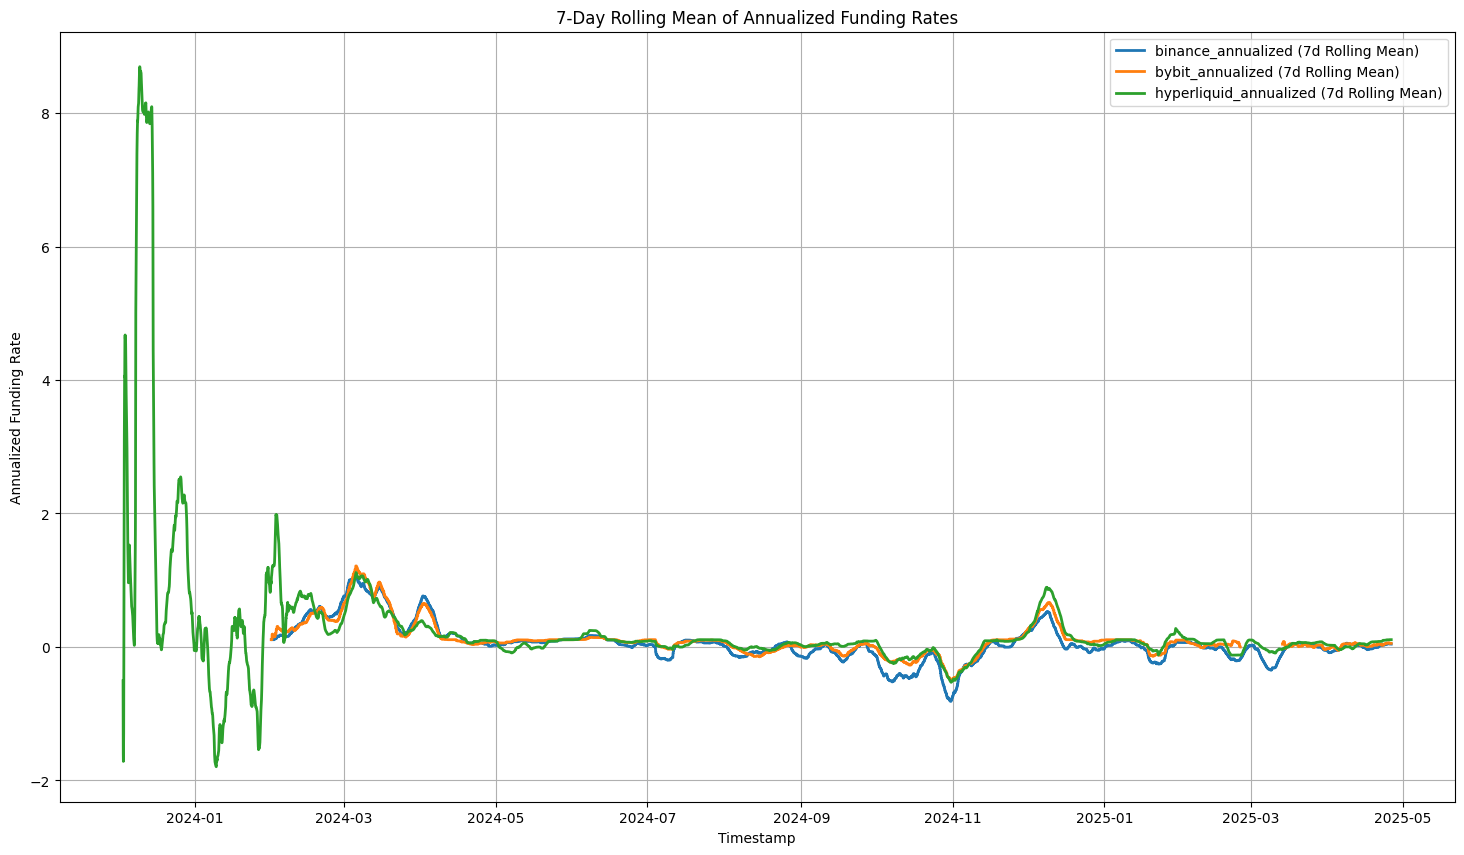

In [20]:
import matplotlib.pyplot as plt

# Define rolling window size (7 days = 168 hours)
rolling_window = 24 * 7

# Calculate 7-day rolling mean
rolling_means = combined_df[annualized_cols].rolling(window=rolling_window, min_periods=1).mean()

# Plot
plt.figure(figsize=(18, 10))
for col in annualized_cols:
    plt.plot(rolling_means.index, rolling_means[col], label=f"{col} (7d Rolling Mean)", linewidth=2)

plt.title('7-Day Rolling Mean of Annualized Funding Rates')
plt.xlabel('Timestamp')
plt.ylabel('Annualized Funding Rate')
plt.grid(True)
plt.legend()
plt.show()
